In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

/Users/abuca/MachineLearning/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
data = pd.read_csv('Appendicitis.csv',index_col='Index')

In [3]:
labels_description = {
    'V1':'Выраженные боли в правой подвздошной области, бинарный',
    'V2':'Боли более 48 часов, бинарный',
    'V3':'Боли более 24 часов, бинарный',
    'V4':'Боли более 12 часов, бинарный',
    'V5':'Частота пульса менее 80 уд/мин, бинарный',
    'V6':'Частота пульса менее 100 уд/мин, бинарный',
    'V7':'Лейкоциты крови ниже 8 тыс. ед., бинарный',
    'V8':'Лейкоциты крови ниже 14 тыс. ед., бинарный',
    'V9':'Язык обложен, бинарный',
    'V10':'Симптом Щеткина-Блюмберга выражен, бинарный',
    'V11':'Симптом Ровзинга выражен, бинарный',
    'V12':'Защитное мышечное напряжение выражено, бинарный',
    'Type': 'Тип аппендицита (0 - отсутствует, 1 - гангренозный, 2 - флегмонозный, 3 - катаральный), категориальный'
}

Посмотрим на данные

In [4]:
data.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,Type
Index,,,,,,,,,,,,,
1,1,0,0,1,1,1,0,1,1,1,0,1,1
2,1,0,1,1,0,1,0,1,1,1,0,1,1
3,1,0,0,1,1,1,0,0,1,1,1,1,1
4,1,0,1,1,0,0,1,1,1,0,1,1,1
5,1,0,0,1,0,1,0,1,1,1,1,0,1


In [5]:
for (t,d) in labels_description.iteritems():
    print t+' - '+d

Type - Тип аппендицита (0 - отсутствует, 1 - гангренозный, 2 - флегмонозный, 3 - катаральный), категориальный
V12 - Защитное мышечное напряжение выражено, бинарный
V10 - Симптом Щеткина-Блюмберга выражен, бинарный
V11 - Симптом Ровзинга выражен, бинарный
V1 - Выраженные боли в правой подвздошной области, бинарный
V2 - Боли более 48 часов, бинарный
V3 - Боли более 24 часов, бинарный
V4 - Боли более 12 часов, бинарный
V5 - Частота пульса менее 80 уд/мин, бинарный
V6 - Частота пульса менее 100 уд/мин, бинарный
V7 - Лейкоциты крови ниже 8 тыс. ед., бинарный
V8 - Лейкоциты крови ниже 14 тыс. ед., бинарный
V9 - Язык обложен, бинарный


In [6]:
print 'Количество признаков {0:d}'.format(data.shape[1])
print 'Количество объектов {0:d}'.format(data.shape[0])

Количество признаков 13
Количество объектов 103


Объектов довольно мало, следовательно стоит использовать простые модели.

In [7]:
print 'Количество объектов с пропущенными данными {0:d}'.format(data.shape[0] - data.dropna().shape[0])

Количество объектов с пропущенными данными 0


In [8]:
print 'Количество объектов без аппендицита {0:d}'.format(data.Type.value_counts()[0])
print 'Количество объектов с гангренозным аппендицитом {0:d}'.format(data.Type.value_counts()[1])
print 'Количество объектов с флегмонозным аппендицитом {0:d}'.format(data.Type.value_counts()[2])
print 'Количество объектов с катаральный аппендицитом {0:d}'.format(data.Type.value_counts()[3])

Количество объектов без аппендицита 24
Количество объектов с гангренозным аппендицитом 28
Количество объектов с флегмонозным аппендицитом 25
Количество объектов с катаральный аппендицитом 26


Выборка довольно сбалансированна. Нет смысла делать поправку на несбалансированность классов.

Построим гистограммы для каждого признака, это поможет визуально оценить их информативность.

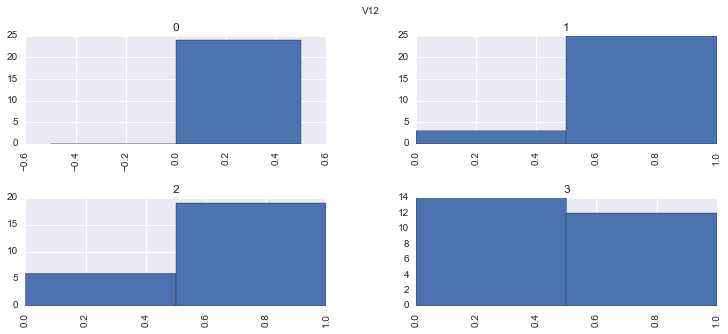

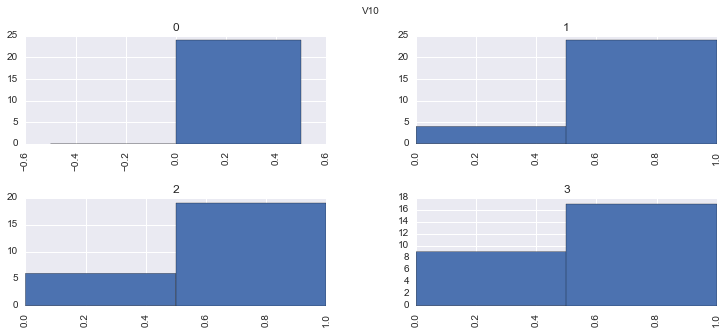

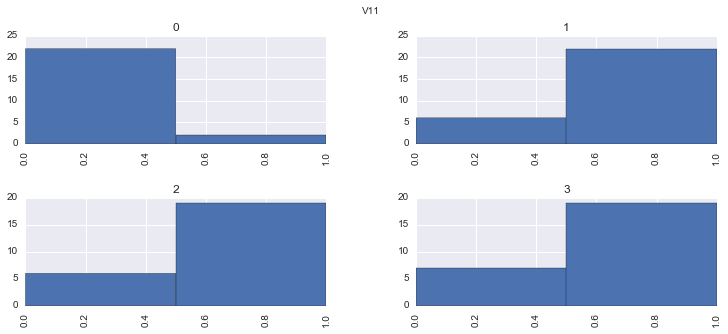

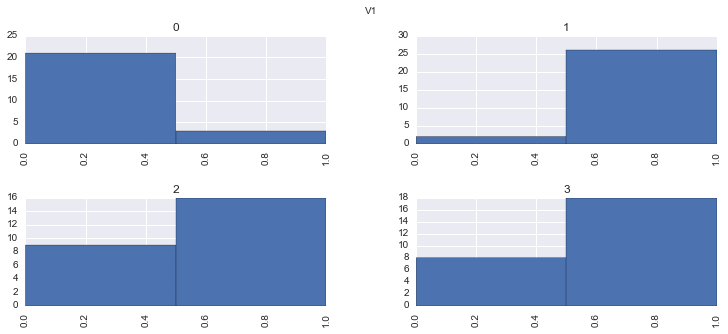

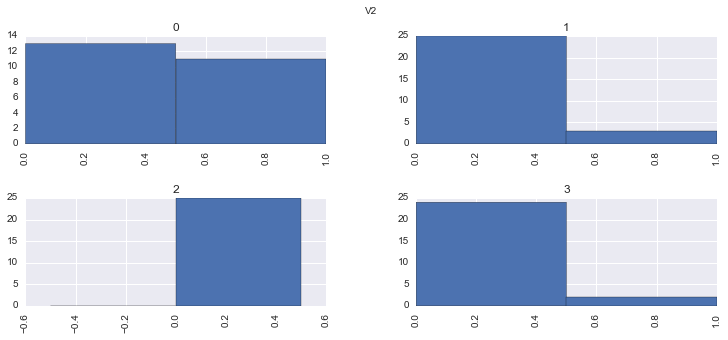

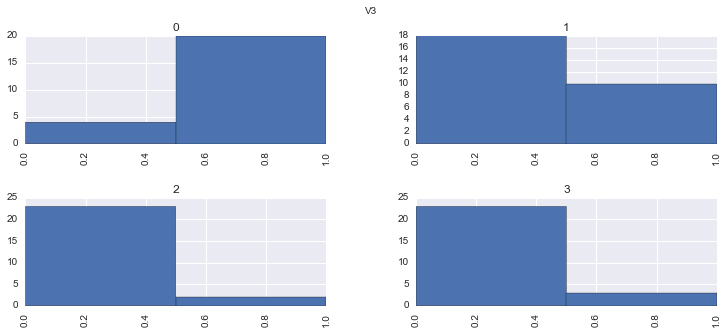

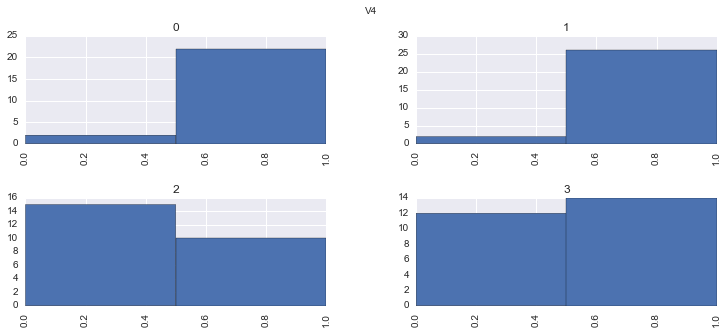

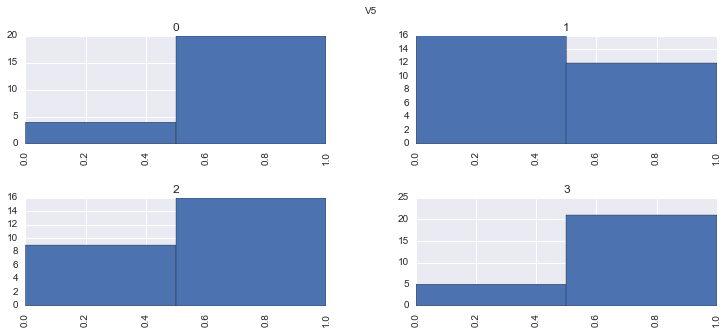

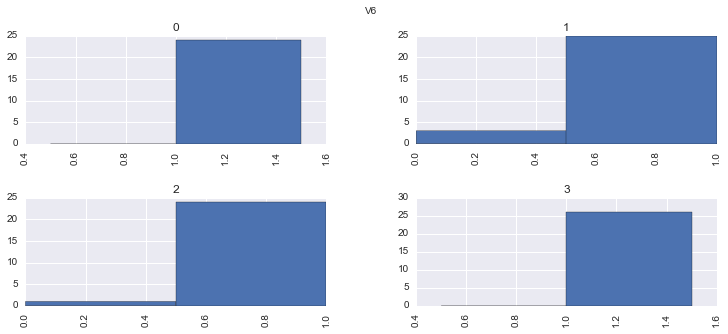

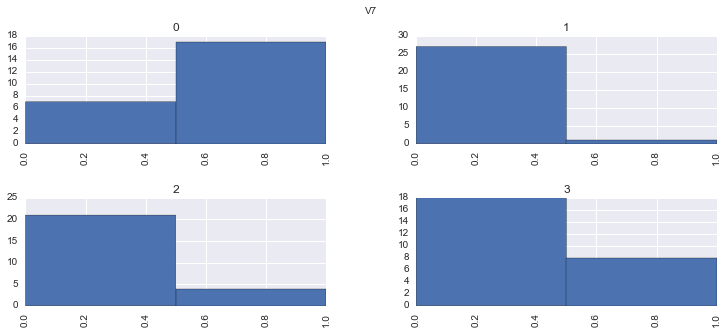

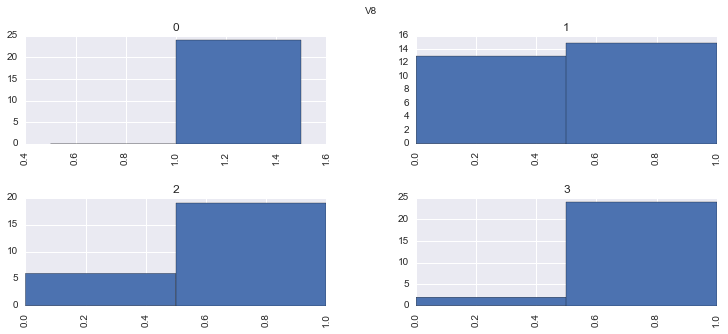

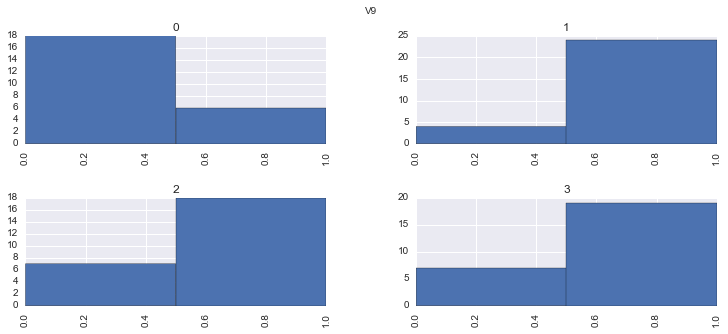

In [9]:
for (t,d) in labels_description.items()[1:]:
    data.hist(column=t,by=data['Type'], bins=2, figsize=(12,5))
    plt.suptitle(t)

Рассмотрим корреляцию Мэтьюса для всех признаков. Выражают есть ли корреляция между возникновением аппендицита (любого типа) и признаками?

In [10]:
from sklearn.metrics import matthews_corrcoef
from scipy.stats import chi2_contingency
from statsmodels.sandbox.stats.multicomp import multipletests 

In [11]:
def matthews_appendix_features_corr(feature_name):
    feature_true_and_sick = data.query(feature_name+' == 1 & Type != 0').shape[0]
    feature_false_and_sick = data.query(feature_name+' == 0 & Type != 0').shape[0]
    feature_true_and_not_sick = data.query(feature_name+' == 1 & Type == 0').shape[0]
    feature_false_and_not_sick = data.query(feature_name+' == 0 & Type == 0').shape[0]
    sick = np.hstack((np.ones(feature_true_and_sick+feature_false_and_sick),
                      np.zeros(feature_true_and_not_sick+feature_false_and_not_sick)))
    feature = np.hstack((np.zeros(feature_true_and_sick),
                         np.ones(feature_false_and_sick),
                         np.zeros(feature_true_and_not_sick),
                         np.ones(feature_false_and_not_sick)))
    corr = matthews_corrcoef(sick,feature)
    p = chi2_contingency([
                         [feature_true_and_sick,
                          feature_false_and_sick],
                         [feature_true_and_not_sick,
                          feature_false_and_not_sick]],
                          correction=corr)[1]
    return (corr,p)

In [12]:
matthews_correlations = pd.DataFrame(columns=['feature','description','correlation','p'])
for i,feature in enumerate(labels_description.items()[1:]):
    (corr,p) = matthews_appendix_features_corr(feature[0])
    matthews_correlations.loc[i] = [feature[0],feature[1],corr,p]
reject, p_corrected, a1, a2 = multipletests(matthews_correlations.p, 
                                            alpha = 0.05, 
                                            method = 'fdr_bh') 
matthews_correlations['p'] = p_corrected
matthews_correlations['reject'] = reject

In [13]:
matthews_correlations

,feature,description,correlation,p,reject
0,V12,"Защитное мышечное напряжение выражено, бинарный",-0.601641,2.583200e-08,True
1,V10,"Симптом Щеткина-Блюмберга выражен, бинарный",-0.651079,2.247595e-09,True
2,V11,"Симптом Ровзинга выражен, бинарный",-0.583957,5.128163e-08,True
3,V1,"Выраженные боли в правой подвздошной области, ...",-0.550359,2.153055e-07,True
4,V2,"Боли более 48 часов, бинарный",0.461045,1.974556e-05,True
5,V3,"Боли более 24 часов, бинарный",0.574318,7.106811e-08,True
6,V4,"Боли более 12 часов, бинарный",0.261527,1.966697e-02,True
7,V5,"Частота пульса менее 80 уд/мин, бинарный",0.191557,9.800189e-02,False
8,V6,"Частота пульса менее 100 уд/мин, бинарный",0.110791,6.022212e-01,False
9,V7,"Лейкоциты крови ниже 8 тыс. ед., бинарный",0.505961,2.138459e-06,True


Проверка гипотезы отличия от нуля корреляции Мэтьюса, показала отличиее от нуля на всех признаках, кроме связанных с пульсом. Действительно, судя по гистограмме V5 признак ведет себя похоже для случаев отсутсвия аппендицита и аппендицита третьего типа. Гистограммы признака V6 в целом показывают схожую картину для всех случаев. 

Теперь рассмотрим способность признаков разделять виды аппендицита, с помощью коэффициента V Крамера.

In [14]:
def cramer_V_appendix_features_coef(feature_name):
    feature_true_and_type_1 = data.query(feature_name+' == 1 & Type == 1').shape[0]
    feature_false_and_type_1 = data.query(feature_name+' == 0 & Type == 1').shape[0]
    feature_true_and_type_2 = data.query(feature_name+' == 1 & Type == 2').shape[0]
    feature_false_and_type_2 = data.query(feature_name+' == 0 & Type == 2').shape[0]
    feature_true_and_type_3 = data.query(feature_name+' == 1 & Type == 3').shape[0]
    feature_false_and_type_3 = data.query(feature_name+' == 0 & Type == 3').shape[0]
    
    chi2 = chi2_contingency([[feature_true_and_type_1,feature_true_and_type_2,feature_true_and_type_3],
                      [feature_false_and_type_1,feature_false_and_type_2,feature_false_and_type_3]])
    
    V = np.sqrt(chi2[0]/(data.query('Type != 0').shape[0]))
    return (V,chi2[1])

In [15]:
cramer_V = pd.DataFrame(columns=['feature','description','V','p'])
for i,feature in enumerate(labels_description.items()[1:]):
    (V,p) = cramer_V_appendix_features_coef(feature[0])
    cramer_V.loc[i] = [feature[0],feature[1],V,p]
reject, p_corrected, a1, a2 = multipletests(cramer_V.p, 
                                            alpha = 0.05, 
                                            method = 'fdr_bh') 
cramer_V['p'] = p_corrected
cramer_V['reject'] = reject

In [16]:
cramer_V

,feature,description,V,p,reject
0,V12,"Защитное мышечное напряжение выражено, бинарный",0.399623,0.010929,True
1,V10,"Симптом Щеткина-Блюмберга выражен, бинарный",0.196501,0.290105,False
2,V11,"Симптом Ровзинга выражен, бинарный",0.053114,0.894551,False
3,V1,"Выраженные боли в правой подвздошной области, ...",0.297220,0.052318,False
4,V2,"Боли более 48 часов, бинарный",0.184147,0.314389,False
5,V3,"Боли более 24 часов, бинарный",0.318082,0.044114,True
6,V4,"Боли более 12 часов, бинарный",0.468912,0.002029,True
7,V5,"Частота пульса менее 80 уд/мин, бинарный",0.323887,0.044114,True
8,V6,"Частота пульса менее 100 уд/мин, бинарный",0.204555,0.287271,False
9,V7,"Лейкоциты крови ниже 8 тыс. ед., бинарный",0.303136,0.052318,False


Коэфициент крамера показывает информативность (наличие корреляции) между типом аппендицита и частотой пульса менее 80 уд/мин (V5). Однако не показывает сзязи между частотой пульса менее 100 уд/мин и типом аппендицита (V6). Признак V6 судя по корреляционному анализу не ифнормативен для определения наличия апендицита, а также его типа. Возможно его следует отбросить.

Для решения задачи многоклассововой классификации на бинарных признаках наиболее походят модели основанные на деревьях принятия решений. В данном случае не имеет смысл использовать сложную модель, т.к. при малом количестве данных высок риск переобучения. Я буду использовать случайный лес. Т.к. в задании неизвесны целевые показатели модели, я буду исползовать усредненный f1 score для оценки качества.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

In [18]:
model = RandomForestClassifier(n_jobs=-1,oob_score = True)

Оптимизируем гиперпараметры по сетке. Тестирование будет производится по 5-fold кросс валидации.

In [19]:
param_grid = {
    'n_estimators': range(10,210,50),
    'max_features': ['sqrt','log2'],
    'max_depth': range(3,21,3)
}

In [20]:
cv_grid = GridSearchCV(estimator=model,param_grid=param_grid, cv= 5,scoring='f1_macro')
cv_grid.fit(data.drop(['Type','V6'],axis=1),data['Type'])
print 'Оптимальные параметры: ',cv_grid.best_params_
print 'Лучший усредненный f1_score: ', cv_grid.best_score_
model = cv_grid.best_estimator_

/Users/abuca/MachineLearning/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Оптимальные параметры:  {'max_features': 'log2', 'n_estimators': 110, 'max_depth': 3}
Лучший усредненный f1_score:  0.671026667507


Оптимальные параметры найдены. Постороим матрицу матрицу ошибок для классификатора с лучшими параметрами. Для этого обучим и протестируем его 100 раз на случайном подмножестве объектов.

In [21]:
cm = np.zeros([4,4],dtype=int)
for i in xrange(1,100):
    xtrain, xtest, ytrain, ytest = train_test_split(data.drop(['Type','V6'],axis=1), data['Type'], test_size=0.25,stratify=data['Type'])
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    cm += confusion_matrix(ytest,ypred)

In [22]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[577   0   0  17]
 [  2 574  63  54]
 [ 23 134 280 157]
 [ 56 176 215 246]]


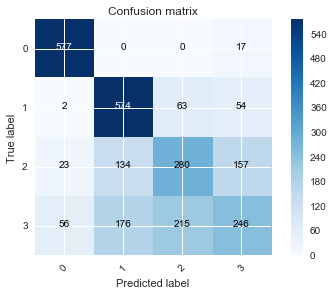

In [23]:
plot_confusion_matrix(cm,classes=['0','1','2','3'], normalize=False,title='Confusion matrix')

Как видно для данной модели наиболее сложным является разделение флегмонозного и гангренозного типа аппендцита. Модель часто их путает. Следовательно дальнейшую работу следует направить на поиск признака хорошо разделающего эти классы. В предложенном датасете есть подобный признак, это боли более 48 часов. Однако возникает вопрос о его надежности, т.к. не понятный причины исчезновения болей у пациентов с флегмонозным типом аппендицита. Переделывать модель основываясь на необъяснимом признаке нелогично. Данная модель не всегда учитывает данный признак, т.к. лес строиться с использованием метода случайных подространств. Усложнять модель на малом количестве данных также нецелесообразно.